In [6]:
# Load libraries

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import os
import json
import sys
from datetime import datetime
import matplotlib.dates as mdates
from matplotlib.dates import MO  # Monday as start of week

# Append utils to path for logo import
sys.path.append("utils")
from logo import add_logo

date = 'April 16th, 2025'


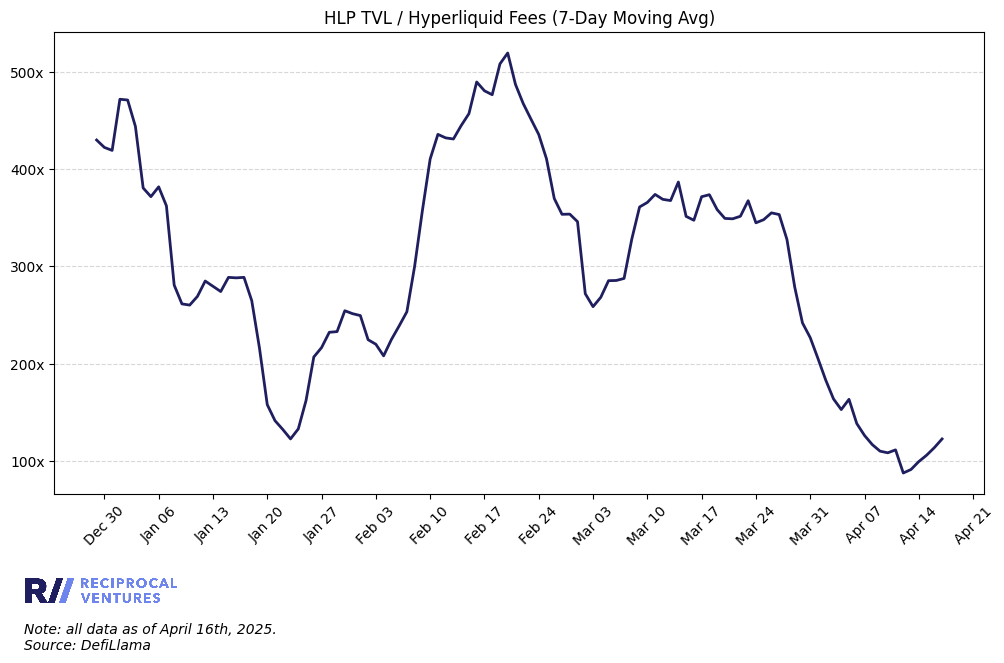

          date           tvl     fees  tvl-to-fees  tvl-to-fees-7d
105 2025-04-08  1.499814e+08  1746313    85.884597      116.903407
106 2025-04-09  1.482302e+08  2837027    52.248431      110.154291
107 2025-04-10  1.498008e+08  1686123    88.843334      108.456529
108 2025-04-11  1.495930e+08  1327396   112.696559      111.473799
109 2025-04-12  1.559157e+08  1164323   133.911057       87.702156
110 2025-04-13  1.576559e+08  1365048   115.494737       91.342665
111 2025-04-14  1.598938e+08  1491560   107.199012       99.468247
112 2025-04-15  1.603078e+08  1221402   131.248983      105.948873
113 2025-04-16  1.612290e+08  1508963   106.847533      113.748745
114 2025-04-17  1.645104e+08  1085608   151.537613      122.705071


In [7]:
# Load Hyperliquid fees data
with open("raw-data/defillama-raw-data/defillama_hyperliquid-fees.json", "r") as f:
    fee_data = json.load(f)

fee_df = pd.DataFrame(fee_data["totalDataChart"], columns=["timestamp", "fees"])
fee_df["date"] = pd.to_datetime(fee_df["timestamp"], unit="s")
fee_df = fee_df[["date", "fees"]]

# Load HLP TVL data
with open("raw-data/defillama-raw-data/defillama_HLP.json", "r") as f:
    hlp_data = json.load(f)

hlp_raw = hlp_data["chainTvls"]["Hyperliquid"]["tvl"]
hlp_df = pd.DataFrame(hlp_raw)
hlp_df["date"] = pd.to_datetime(hlp_df["date"], unit="s")
hlp_df = hlp_df.rename(columns={"totalLiquidityUSD": "tvl"})
hlp_df = hlp_df[["date", "tvl"]]

# Merge datasets
df = pd.merge(hlp_df, fee_df, on="date", how="inner")
df["tvl-to-fees"] = df["tvl"] / df["fees"]

# Calculate trailing 7-day average
df["tvl-to-fees-7d"] = df["tvl-to-fees"].rolling(window=7).mean()

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df["date"], df["tvl-to-fees-7d"], color="#1f1f60", linewidth=2, label="7D Avg")

# X-axis formatting for weekly ticks
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# Y-axis formatting
ax.set_title("HLP TVL / Hyperliquid Fees (7-Day Moving Avg)")
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:,.0f}x'))

# X-axis formatting: show ticks weekly, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)

plt.grid(axis='y', linestyle='--', alpha=0.5)
add_logo(ax, position=(0.05, -0.21))
plt.figtext(0.1, -0.15, f"Note: all data as of {date}.\nSource: DefiLlama", ha='left', fontsize=10, style='italic')

# Save plot
if not os.path.exists("plots"):
    os.makedirs("plots")
plt.savefig("plots/tvl-to-fees_ratio_7d_avg.png", dpi=300, bbox_inches='tight')
plt.show()

# Print sample of the dataset with 7D average
print(df[["date", "tvl", "fees", "tvl-to-fees", "tvl-to-fees-7d"]].tail(10))

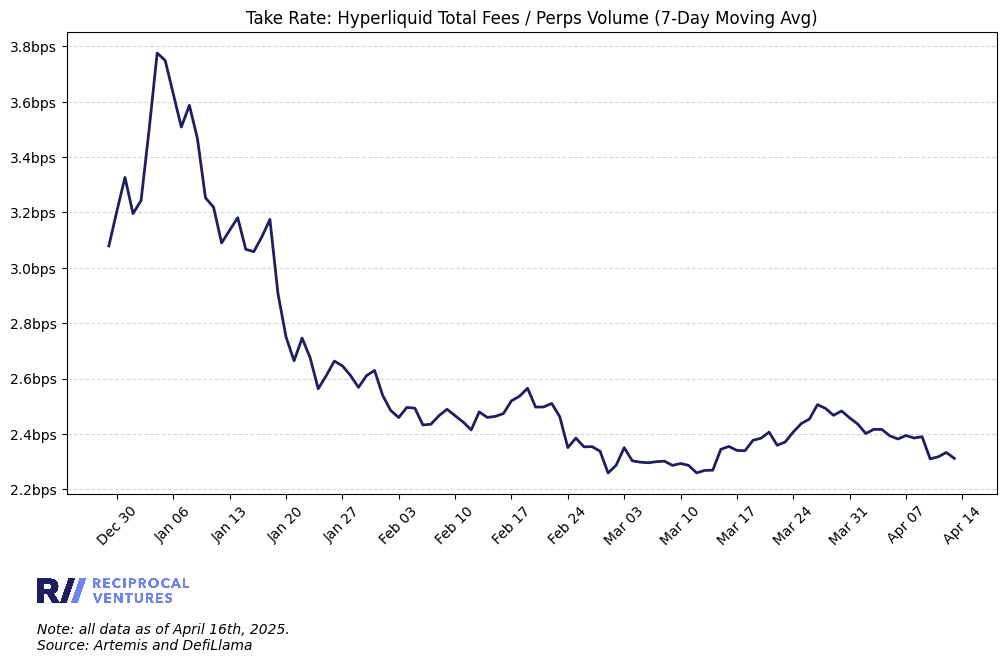

          date     fees  perps-volume  take-rate  take-rate-7d
102 2025-04-05   545156  2.430774e+09   2.242726      2.392919
103 2025-04-06  1772829  7.538398e+09   2.351732      2.381593
104 2025-04-07  3117000  1.330997e+10   2.341853      2.394353
105 2025-04-08  1746313  7.663480e+09   2.278747      2.385129
106 2025-04-09  2837027  1.244462e+10   2.279722      2.389800
107 2025-04-10  1686123  7.229337e+09   2.332334      2.309830
108 2025-04-11  1327396  5.544363e+09   2.394136      2.317321
109 2025-04-12  1164323  4.949383e+09   2.352461      2.332998
110 2025-04-13  1365048  6.199138e+09   2.201996      2.311607
111 2025-04-14  1491560           NaN        NaN           NaN


In [8]:
# Load Hyperliquid fees data
with open("raw-data/defillama-raw-data/defillama_hyperliquid-fees.json", "r") as f:
    fee_data = json.load(f)

fee_df = pd.DataFrame(fee_data["totalDataChart"], columns=["timestamp", "fees"])
fee_df["date"] = pd.to_datetime(fee_df["timestamp"], unit="s")
fee_df = fee_df[["date", "fees"]]

# Load Hyperliquid perps volume data
volume_df = pd.read_csv('raw-data/artemis-raw-data/artemis_perps-trading-volume.csv')
volume_df['Date'] = pd.to_datetime(volume_df['Date'], format='%d-%b-%y')
volume_df.rename(columns={'Date': 'date', 'Hyperliquid': 'perps-volume'}, inplace=True)

# Merge datasets
df = pd.merge(volume_df, fee_df, on="date", how="inner")
df["take-rate"] = df["fees"] / df["perps-volume"] * 10000  # Convert to BPS

# Calculate trailing 7-day average
df["take-rate-7d"] = df["take-rate"].rolling(window=7).mean()

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df["date"], df["take-rate-7d"], color="#1f1f60", linewidth=2, label="7D Avg")

# X-axis formatting: show ticks weekly, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)

# Y-axis formatting
ax.set_title("Take Rate: Hyperliquid Total Fees / Perps Volume (7-Day Moving Avg)")
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:.1f}bps'))

plt.grid(axis='y', linestyle='--', alpha=0.5)
add_logo(ax, position=(0.05, -0.21))
plt.figtext(0.1, -0.15, f"Note: all data as of {date}.\nSource: Artemis and DefiLlama", ha='left', fontsize=10, style='italic')

# Save plot
if not os.path.exists("plots"):
    os.makedirs("plots")
plt.savefig("plots/take-rate_7d_avg.png", dpi=300, bbox_inches='tight')
plt.show()

# Print sample of the dataset with 7D average
print(df[["date", "fees", "perps-volume", "take-rate", "take-rate-7d"]].tail(10))


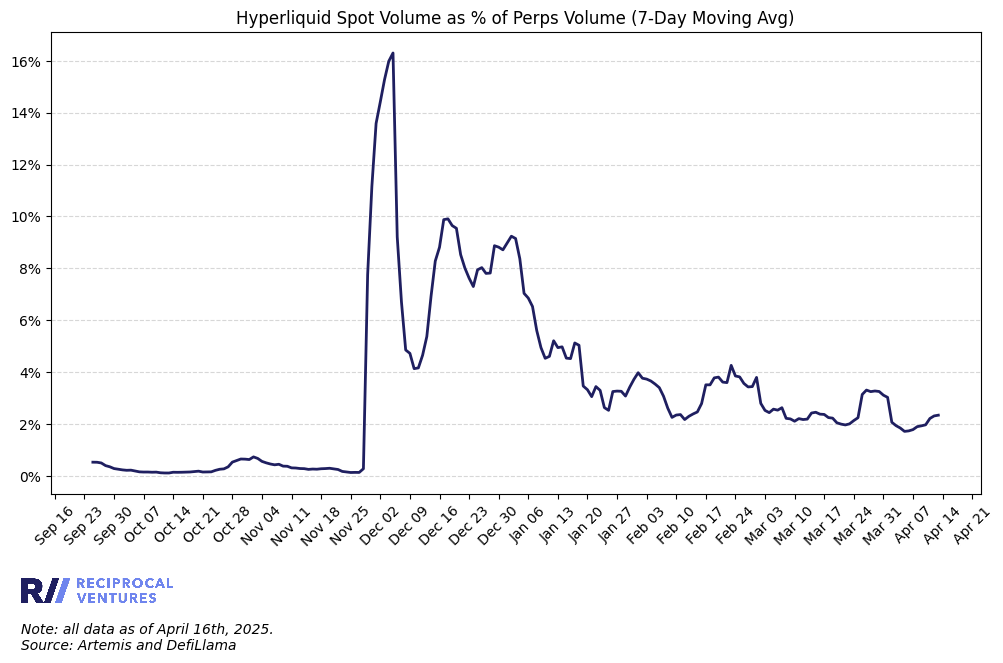

          date  spot-volume  perps-volume  spot-volume-percent-perps-volume  \
198 2025-04-05     42672433  2.430774e+09                          1.755508   
199 2025-04-06    148050393  7.538398e+09                          1.963950   
200 2025-04-07    254918742  1.330997e+10                          1.915246   
201 2025-04-08    163870707  7.663480e+09                          2.138333   
202 2025-04-09    256513559  1.244462e+10                          2.061241   
203 2025-04-10    165359677  7.229337e+09                          2.287342   
204 2025-04-11    187070232  5.544363e+09                          3.374062   
205 2025-04-12    121367900  4.949383e+09                          2.452183   
206 2025-04-13    134246965  6.199138e+09                          2.165575   
207 2025-04-14    126974634           NaN                               NaN   

     spot-volume-percent-perps-volume-7d  
198                             1.717844  
199                             1.736498  
2

In [9]:
# Load Hyperliquid spot volume data
with open("raw-data/defillama-raw-data/defillama_hyperliquid-spot-volumes.json", "r") as f:
    spot_volume_data = json.load(f)

spot_volume_df = pd.DataFrame(spot_volume_data["totalDataChart"], columns=["timestamp", "spot-volume"])
spot_volume_df["date"] = pd.to_datetime(spot_volume_df["timestamp"], unit="s")
spot_volume_df = spot_volume_df[["date", "spot-volume"]]

# Load Hyperliquid perps volume data
perps_volume_df = pd.read_csv('raw-data/artemis-raw-data/artemis_perps-trading-volume.csv')
perps_volume_df['Date'] = pd.to_datetime(perps_volume_df['Date'], format='%d-%b-%y')
perps_volume_df.rename(columns={'Date': 'date', 'Hyperliquid': 'perps-volume'}, inplace=True)

# Merge datasets
df = pd.merge(perps_volume_df, spot_volume_df, on="date", how="inner")
df["spot-volume-percent-perps-volume"] = df["spot-volume"] / df["perps-volume"] * 100 # convert to %

# Calculate trailing 7-day average
df["spot-volume-percent-perps-volume-7d"] = df["spot-volume-percent-perps-volume"].rolling(window=7).mean()

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df["date"], df["spot-volume-percent-perps-volume-7d"], color="#1f1f60", linewidth=2, label="7D Avg")

# X-axis formatting: show ticks weekly, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)

# Y-axis formatting
ax.set_title("Hyperliquid Spot Volume as % of Perps Volume (7-Day Moving Avg)")
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:.0f}%'))

plt.grid(axis='y', linestyle='--', alpha=0.5)
add_logo(ax, position=(0.05, -0.21))
plt.figtext(0.1, -0.15, f"Note: all data as of {date}.\nSource: Artemis and DefiLlama", ha='left', fontsize=10, style='italic')

# Save plot
if not os.path.exists("plots"):
    os.makedirs("plots")
plt.savefig("plots/spot-volume-percent-perps-volume_7d_avg.png", dpi=300, bbox_inches='tight')
plt.show()

# Print sample of the dataset with 7D average
print(df[["date", "spot-volume", "perps-volume", "spot-volume-percent-perps-volume", "spot-volume-percent-perps-volume-7d"]].tail(10))


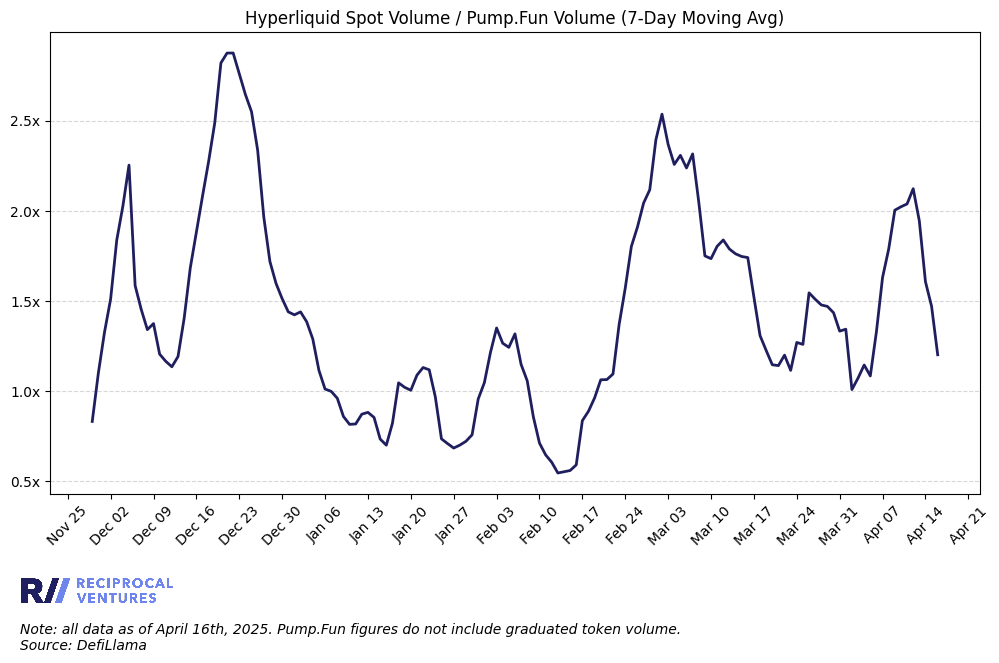

          date  hyperliquid-spot-volume  hyperliquid-spot-volume  \
135 2025-04-07                254918742                254918742   
136 2025-04-08                163870707                163870707   
137 2025-04-09                256513559                256513559   
138 2025-04-10                165359677                165359677   
139 2025-04-11                187070232                187070232   
140 2025-04-12                121367900                121367900   
141 2025-04-13                134246965                134246965   
142 2025-04-14                126974634                126974634   
143 2025-04-15                120978471                120978471   
144 2025-04-16                155624952                155624952   

     hyperliquid-memecoin-market-share  hyperliquid-memecoin-market-share-7d  
135                           3.323031                              1.630634  
136                           1.860535                              1.787698  
137           

In [10]:
# Load Hyperliquid spot volume data
with open("raw-data/defillama-raw-data/defillama_hyperliquid-spot-volumes.json", "r") as f:
    hyperliquid_spot_volume_data = json.load(f)

hyperliquid_spot_volume_df = pd.DataFrame(hyperliquid_spot_volume_data["totalDataChart"], columns=["timestamp", "hyperliquid-spot-volume"])
hyperliquid_spot_volume_df["date"] = pd.to_datetime(hyperliquid_spot_volume_df["timestamp"], unit="s")
hyperliquid_spot_volume_df = hyperliquid_spot_volume_df[["date", "hyperliquid-spot-volume"]]

# Load Pump.Fun volume data
with open("raw-data/defillama-raw-data/defillama_pumpfun-spot-volumes.json", "r") as f:
    pumpfun_spot_volume_data = json.load(f)

pumpfun_spot_volume_df = pd.DataFrame(pumpfun_spot_volume_data["totalDataChart"], columns=["timestamp", "pumpfun-spot-volume"])
pumpfun_spot_volume_df["date"] = pd.to_datetime(pumpfun_spot_volume_df["timestamp"], unit="s")
pumpfun_spot_volume_df = pumpfun_spot_volume_df[["date", "pumpfun-spot-volume"]]

# Merge datasets
df = pd.merge(hyperliquid_spot_volume_df, pumpfun_spot_volume_df, on="date", how="inner")
df["hyperliquid-memecoin-market-share"] = df["hyperliquid-spot-volume"] / df["pumpfun-spot-volume"]

# Calculate trailing 7-day average
df["hyperliquid-memecoin-market-share-7d"] = df["hyperliquid-memecoin-market-share"].rolling(window=7).mean()

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df["date"], df["hyperliquid-memecoin-market-share-7d"], color="#1f1f60", linewidth=2, label="7D Avg")

# X-axis formatting: show ticks weekly, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)

# Y-axis formatting
ax.set_title("Hyperliquid Spot Volume / Pump.Fun Volume (7-Day Moving Avg)")
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:.1f}x'))

plt.grid(axis='y', linestyle='--', alpha=0.5)
add_logo(ax, position=(0.05, -0.21))
plt.figtext(0.1, -0.15, f"Note: all data as of {date}. Pump.Fun figures do not include graduated token volume.\nSource: DefiLlama", ha='left', fontsize=10, style='italic')

# Save plot
if not os.path.exists("plots"):
    os.makedirs("plots")
plt.savefig("plots/hyperliquid-to-pumpfun-volume-ratio_7d_avg.png", dpi=300, bbox_inches='tight')
plt.show()

# Print sample of the dataset with 7D average
print(df[["date", "hyperliquid-spot-volume", "hyperliquid-spot-volume", "hyperliquid-memecoin-market-share", "hyperliquid-memecoin-market-share-7d"]].tail(10))